# RAIL Model Training and Saving

## Load Catalog and Train Model

Use RAIL Catalog Loader and whatever deep learning tools to create a model and train it to reproduce the input catalog

In [1]:
%pylab inline 

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../../jax-nf/')

from tensorflow_probability.python.internal.backend import jax as tf
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

Populating the interactive namespace from numpy and matplotlib


In [2]:
from jax_nf.real_nvp import RealNVP

In [3]:
from flax import nn
import jax
import jax.numpy as np
import numpy as onp
import flax 

tfb = tfp.bijectors
tfd = tfp.distributions

In [4]:
from catalogLoader import catalogLoader

### Load Catalog

RAIL has its own small wrapper around `gcr-catalogs` that loads a catalog based upon a configuration file that can make sure to specify the same catalog parameters to be consistent when training with different models or different model parameters.

In [5]:
test_catalog = catalogLoader('sample_catalog_config.yaml')

In [6]:
test_cat_df = test_catalog.get_catalog_mags_and_redshift()

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_df, validation_df = train_test_split(test_cat_df, train_size=0.8, random_state=17)

In [9]:
r_mag_mean = onp.mean(test_cat_df['mag_true_r_lsst'])
r_mag_stdev = onp.std(test_cat_df['mag_true_r_lsst'])

In [10]:
r_mag_mean, r_mag_stdev

(25.389461004574397, 1.420547244275682)

In [11]:
len(train_df), len(validation_df)

(11941700, 2985426)

Text(0.5, 1.0, 'Cross validation dataset')

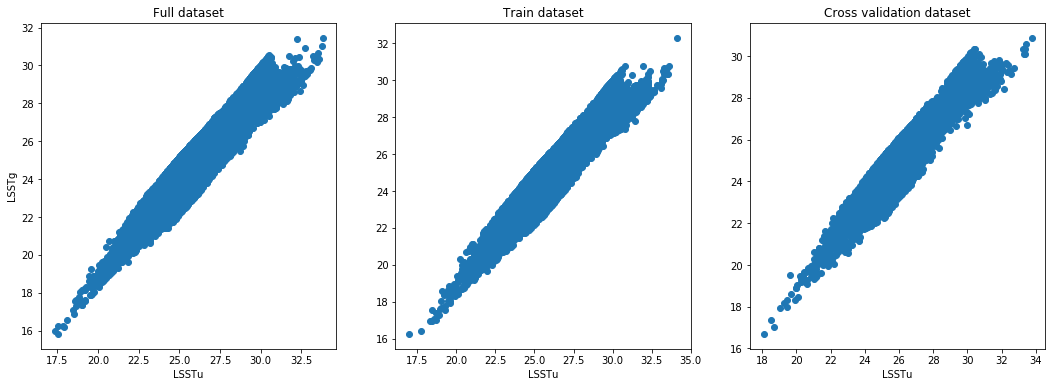

In [12]:
fig = plt.figure(figsize=(18, 6))
fig.add_subplot(1,3,1)
plt.scatter(test_cat_df['mag_true_u_lsst'][::100], test_cat_df['mag_true_g_lsst'][::100])
plt.xlabel('LSSTu')
plt.ylabel('LSSTg')
plt.title('Full dataset')
fig.add_subplot(1,3,2)
plt.scatter(train_df['mag_true_u_lsst'][::100], train_df['mag_true_g_lsst'][::100])
plt.xlabel('LSSTu')
plt.title('Train dataset')
fig.add_subplot(1,3,3)
plt.scatter(validation_df['mag_true_u_lsst'][::100], validation_df['mag_true_g_lsst'][::100])
plt.xlabel('LSSTu')
plt.title('Cross validation dataset')

### Create model

In [13]:
@nn.module
def NeuralSplineCoupling(x, nunits, nbins=32):

  def bin_positions(x):
    x = np.reshape(x, [-1, nunits, nbins])
    return nn.activation.softmax(x, axis=-1) *  (2. - nbins * 1e-2) + 1e-2
  
  def slopes(x):
    x = np.reshape(x, [-1, nunits, nbins - 1])
    return nn.activation.softplus(x) + 1e-2

  # Let's have one more non stupid layer
  net = nn.leaky_relu(nn.Dense(x, 128))
  net = nn.leaky_relu(nn.Dense(net, 128))

  bin_widths = bin_positions(nn.Dense(net, nunits*nbins))
  bin_heights = bin_positions(nn.Dense(net, nunits*nbins))
  knot_slopes = slopes(nn.Dense(net, nunits*(nbins-1)))

  return tfb.RationalQuadraticSpline(
            bin_widths=bin_widths,
            bin_heights=bin_heights,
            knot_slopes=knot_slopes)

In [14]:
d=7
@nn.module
def NeuralSplineFlow(x):
    
    spline1 = NeuralSplineCoupling.shared(name='spline1')
    spline2 = NeuralSplineCoupling.shared(name='spline2')
    
    # Computes the likelihood of these x
    chain = tfb.Chain([
        tfb.Scale(10),
        RealNVP(d//2, bijector_fn=spline1),
        tfb.Permute(np.arange(d)[::-1]),
        RealNVP(d//2, bijector_fn=spline2),
        tfb.Permute(np.arange(d)[::-1]),
        tfb.Scale(0.1)
    ])
    
    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))
    
    return nvp.log_prob(x)

In [15]:
dummy_input = np.zeros((1,d))
res, params = NeuralSplineFlow.init(jax.random.PRNGKey(0), dummy_input)

/global/homes/b/brycek/.conda/envs/bryce-desc/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/global/homes/b/brycek/.conda/envs/bryce-desc/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/global/homes/b/brycek/.conda/envs/bryce-desc/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configurat

In [16]:
model = nn.Model(NeuralSplineFlow, params)

In [17]:
@jax.jit
def train_step(optimizer, batch):
    
    def loss_fn(model):
        log_prob = model(batch['x'])
        return -np.mean(log_prob)
    
    loss, grad = jax.value_and_grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return loss, optimizer

In [18]:
# Experimenting with only a fixed number of points
batch_size=1024
def get_batch():
    rand_select = train_df.sample(n=batch_size, replace=False)
    # These are our features: (redshift, r_mag (normalized), colors)
    x = np.array([rand_select['redshift_true'].values, 
                  (rand_select['mag_true_r_lsst'].values - r_mag_mean)/r_mag_stdev,
                  rand_select['mag_true_u_lsst'].values - rand_select['mag_true_g_lsst'].values,
                  rand_select['mag_true_g_lsst'].values - rand_select['mag_true_r_lsst'].values,
                  rand_select['mag_true_r_lsst'].values - rand_select['mag_true_i_lsst'].values,
                  rand_select['mag_true_i_lsst'].values - rand_select['mag_true_z_lsst'].values,
                  rand_select['mag_true_z_lsst'].values - rand_select['mag_true_y_lsst'].values])
    x = x.T
    return {'x': x}

In [19]:
val_batch_size=2048
def get_validation_sample():
    rand_select = validation_df.sample(n=val_batch_size, replace=False)
    x = np.array([rand_select['redshift_true'].values, 
                  (rand_select['mag_true_r_lsst'].values - r_mag_mean)/r_mag_stdev,
                  rand_select['mag_true_u_lsst'].values - rand_select['mag_true_g_lsst'].values,
                  rand_select['mag_true_g_lsst'].values - rand_select['mag_true_r_lsst'].values,
                  rand_select['mag_true_r_lsst'].values - rand_select['mag_true_i_lsst'].values,
                  rand_select['mag_true_i_lsst'].values - rand_select['mag_true_z_lsst'].values,
                  rand_select['mag_true_z_lsst'].values - rand_select['mag_true_y_lsst'].values])
    x = x.T
    return {'x': x}

### Train model

In [21]:
optimizer = flax.optim.Adam(learning_rate=0.001).create(model)
losses = []
validation_losses = []

In [22]:
for i in range(2000):
    batch = get_batch()
    l, optimizer = train_step(optimizer, batch)
    losses.append(l)
    if  i % 100 == 0:
        print(l)
        val_batch = get_validation_sample()
        validation_losses.append(-np.mean(optimizer.target(val_batch['x'])))

8.797399
0.17921564
-1.463968
-1.5991977
-2.4084787
-2.6913269
-2.859646
-2.9926813
-3.4245057
-3.093154
-3.1437109
-3.655465
-3.775304
-3.84296
-3.655105
-3.8880358
-3.5684688
-3.660256
-4.156397


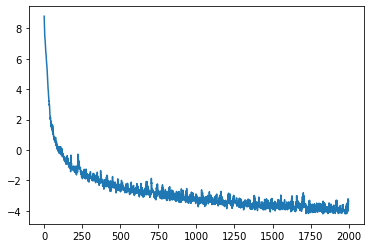

In [23]:
plot(losses)

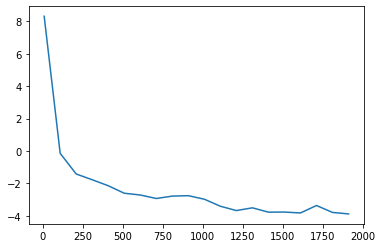

In [24]:
plot(np.arange(10, 2001, 100), validation_losses)

In [33]:
optimizer.state_dict()['dataset_params'] = {}

In [38]:
model_dict = {}
model_dict['optimizer'] = optimizer.state_dict()

In [42]:
dataset_params = {'r_mag_mean': r_mag_mean, 'r_mag_stdev': r_mag_stdev}

In [44]:
model_dict['dataset_params'] = dataset_params

### Save Model Parameters

In [45]:
import pickle
with open('jax_nf_example_opt.pkl', 'wb') as f:
    pickle.dump(model_dict, f)

In [ ]:
# Is pickling the best way?

## Creating a RAIL generator daughter class

We have a skeleton base class called `baseGenerator.py` that shows the methods expected for any model to plug in to the RAIL `creator` class.

Expected functionality for generator:
 * load_model: Custom code to load a model into the class
 * return_sample: Need to be able to sample from the catalog distribution for (redshift, mag) points. This function should return a pandas dataframe with labelled columns.
 * return_log_prob: For a given point in (redshift, mag) space return the log_probability inside the catalog distribution function at that point.

In [104]:
import pickle
import jax
import pandas as pd
from baseGenerator import baseGenerator
from flax import nn

@nn.module
def NeuralSplineFlowSampler(key, n_samples):
    
    d = 7

    spline1 = NeuralSplineCoupling.shared(name='spline1')
    spline2 = NeuralSplineCoupling.shared(name='spline2')

    # Computes the likelihood of these x
    chain = tfb.Chain([
        tfb.Scale(10),
        RealNVP(d//2, bijector_fn=spline1),
        tfb.Permute(np.arange(d)[::-1]),
        RealNVP(d//2, bijector_fn=spline2),
        tfb.Permute(np.arange(d)[::-1]),
        tfb.Scale(0.1)
    ])
    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))

    return nvp.sample(n_samples, seed=key)

@nn.module
def NeuralSplineFlow(x):
    
    d = 7

    spline1 = NeuralSplineCoupling.shared(name='spline1')
    spline2 = NeuralSplineCoupling.shared(name='spline2')

    # Computes the likelihood of these x
    chain = tfb.Chain([
        tfb.Scale(10),
        RealNVP(d//2, bijector_fn=spline1),
        tfb.Permute(np.arange(d)[::-1]),
        RealNVP(d//2, bijector_fn=spline2),
        tfb.Permute(np.arange(d)[::-1]),
        tfb.Scale(0.1)
    ])

    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))

    return nvp.log_prob(x) 

class jaxNFGenerator(baseGenerator):
    
    def load_model(self, model_param_file):
        
        self.n_dim = 7
        
        with open('jax_nf_example_opt.pkl', 'rb') as g:
            model_dict = pickle.load(g)
        self.dataset_params = model_dict['dataset_params']
        self.opt_state_dict = model_dict['optimizer']
        self.sampler = nn.Model(NeuralSplineFlowSampler, 
                                self.opt_state_dict['target']['params'])
        self.log_prob_return = nn.Model(NeuralSplineFlow, 
                                        self.opt_state_dict['target']['params']) 
    
    def return_sample(self, n_samples, seed=17):
        
        catalog_sample = self.sampler(jax.random.PRNGKey(seed), n_samples)
        sample_df = pd.DataFrame(catalog_sample, columns=['redshift', 'r_mag_normalized',
                                                          'umg', 'gmr', 'rmi', 'imz', 'zmy'])
        sample_df['r'] = (sample_df['r_mag_normalized'] * self.dataset_params['r_mag_stdev']) + \
                                       self.dataset_params['r_mag_mean']
        sample_df['g'] = sample_df['gmr'] + sample_df['r']
        sample_df['u'] = sample_df['umg'] + sample_df['g']
        sample_df['i'] = sample_df['r'] - sample_df['rmi']
        sample_df['z'] = sample_df['i'] - sample_df['imz']
        sample_df['y'] = sample_df['z'] - sample_df['zmy']
        
        return sample_df
    
    def return_log_prob(self, z_mag_datapoints):
        
        datapoints = []
        for dp in z_mag_datapoints:
            new_dp = []
            new_dp.append(dp[0])
            new_dp.append((dp[3] - 
                           self.dataset_params['r_mag_mean'])/self.dataset_params['r_mag_stdev'])
            for idx in range(1, 6):
                new_dp.append(dp[idx] - dp[idx+1])
            datapoints.append(new_dp)
        
        return self.log_prob_return(datapoints)

### Load model

Now we can use this class to load our saved model and generate sample catalogs as well as calculate redshift probability distributions about points in magnitude space.

In [105]:
jax_gen = jaxNFGenerator()

In [106]:
jax_gen.load_model('jax_nf_example_opt.pkl')

In [107]:
sample_cat = jax_gen.return_sample(10000)

/global/homes/b/brycek/.conda/envs/bryce-desc/lib/python3.8/site-packages/jax/numpy/lax_numpy.py:1531: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)
/global/homes/b/brycek/.conda/envs/bryce-desc/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/global/homes/b/brycek/.conda/envs/bryce-desc/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enab

In [108]:
sample_cat

,redshift,r_mag_normalized,umg,gmr,rmi,imz,zmy,r,g,u,i,z,y
0,1.760979,1.781547,1.030416,0.564135,1.224956,1.041759,0.468599,27.920233,28.484368,29.514784,26.695277,25.653518,25.184919
1,1.813347,1.316931,1.304104,0.809164,0.647959,0.749728,0.304879,27.260224,28.069388,29.373492,26.612265,25.862537,25.557658
2,1.014494,0.791624,0.419900,0.567254,0.595965,0.295207,0.540734,26.514000,27.081254,27.501154,25.918036,25.622829,25.082095
3,0.529003,-2.465024,0.212450,0.842413,0.871180,0.303158,0.309199,21.887778,22.730191,22.942641,21.016598,20.713441,20.404242
4,0.778541,0.400097,0.600196,0.585385,0.689787,0.170917,0.085457,25.957817,26.543203,27.143399,25.268031,25.097113,25.011656
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.189075,1.135780,0.613780,0.727428,0.573639,0.239083,0.621856,27.002891,27.730318,28.344099,26.429252,26.190170,25.568314
9996,0.702031,0.586000,0.753504,0.952221,0.894124,0.193731,0.112444,26.221902,27.174123,27.927627,25.327777,25.134046,25.021602
9997,0.323234,0.563792,0.451959,0.547623,0.125615,0.188569,-0.084870,26.190354,26.737977,27.189935,26.064739,25.876170,25.961040
9998,0.951490,-1.312946,0.510897,0.657322,0.530605,0.370810,0.060149,23.524359,24.181681,24.692579,22.993754,22.622944,22.562795


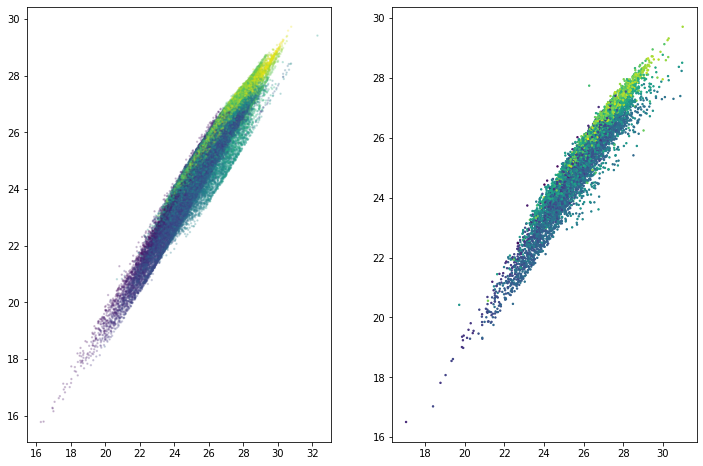

In [109]:
fig = plt.figure(figsize=(12,8))
fig.add_subplot(1,2,1)
plt.scatter(train_df['mag_true_g_lsst'][::100], train_df['mag_true_r_lsst'][::100],
            c=train_df['redshift_true'][::100], s=2, alpha=0.2)
fig.add_subplot(1,2,2)
plt.scatter(sample_cat['g'], sample_cat['r'], c=sample_cat['redshift'], s=2)

In [110]:
u_mag, g_mag, r_mag, i_mag, z_mag, y_mag = np.ones(6)*24
z_log_prob_list = jax_gen.return_log_prob([[z, u_mag, g_mag, r_mag, i_mag, z_mag, y_mag] for z in np.arange(0, 2., .02)])

/global/homes/b/brycek/.conda/envs/bryce-desc/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/global/homes/b/brycek/.conda/envs/bryce-desc/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/global/homes/b/brycek/.con

Text(0.5, 1.0, 'p(z|u,g,r,i,z,y = (24., 24., 24., 24., 24., 24.))')

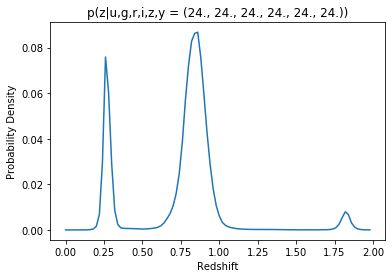

In [111]:
plt.plot(np.arange(0, 2., .02), np.exp(z_log_prob_list)/np.sum(np.exp(z_log_prob_list)))
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('p(z|u,g,r,i,z,y = (24., 24., 24., 24., 24., 24.))')